### York B2E AML Cohort Capstone - Matthew Schoeman - 20 February 2024


Assignment:

Design, build, evaluate, and deploy an ML model to predict customer 
propensity to perform the “Add To Cart” action.  The model should accurately predict whether 
this action will be performed or not based on the features selected or developed from the given 
dataset.  This model is essential as part of the Q2 business goal to increase the return on ad-
spending of the company employing google analytics.

Goals: 

Using the google analytics 360 sample dataset on BigQuery, develop and deploy a model in 
VertexAI to predict when a ‘hit’ will have an event action of “Add To Cart”.  To start with, a 1-
month period of your choice should be used to train the model, with the goal of being able to 
easily substitute in the 12-month period (full dataset) after validating the model.  Because of 
the dataset size, it is assumed that data cleaning and feature selection will take place to test 
and train the model in a timely manner.  All decisions on this must be documented.

Dataset Information: 
https://support.google.com/analytics/answer/7586738  
 
Requirements: 
- All code shall be written in python, SQL, or the GCP console 
- The model will be trained and deployed using GCP 
- All code shall be managed via git 
- The repository shall be named ‘<first_name>-<last_name>-aml-capstone' (all lowercase, 
i.e. Tom Cruise’s repository name is ‘tom-cruise-aml-capstone') 
- All code shall be written by you. Any suspicion of direct code copying shall result in 
termination from this program.

The allowed Python dependencies are: 
- Scikit-learn 
- NumPy 
- SciPy 
- Pandas 
- Seaborn 
- Google-cloud-* 
 
Deliverables: 
- Analysis report covering the following:
    - EDA (exploratory data analysis) 
    - Data pre-processing 
    - Feature Selection and Engineering 
    - Model Choice 
    - Model Evaluation Metrics 
    - Model Tuning 
    - Performance Monitoring & Maintenance Plan 
- Deployed GCP model to respond to prediction requests 
- Deployment documentation – documentation on how the model was deployed to GCP, 
with all necessary steps for redeployment.  
- Project cost report – report on the total cost to get model deployed, including any 
additional cost monitoring or resource optimization done

In [1]:
# Install required libraries
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

In [2]:
# Set project_id
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0] 

In [3]:
# Set BigQuery and Region variables for later use 
BQ_LOCATION = 'US'
REGION = 'us-central1'

In [4]:
# Add additional libraries 
import pandas as pd
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai

In [5]:
# Set bucket variable with project and bucket name
GCS_BUCKET = f"{PROJECT_ID}-matt-aml-cap-bucket"

In [ ]:
# Create a GC Storage bucket in command line for later artifact storage
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://york-bb-cohort-matt-aml-cap-bucket/...


In [7]:
# Set BigQuery dataset variable 
BQ_DATASET = f"{PROJECT_ID}:matt_aml_cap_dataset"

In [ ]:
#Create BiqQuery Dataset from command line 
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

BigQuery error in mk operation: Dataset 'york-bb-cohort:matt_aml_cap_dataset'
already exists.


In [21]:
# Initialize the Vertex Python SDK client
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

In [22]:
%%bigquery --project $PROJECT_ID

# Create a table in dataset from selected month 
CREATE OR REPLACE VIEW matt_aml_cap_dataset.ga_sessions AS (
    SELECT 
        *
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
)

Query is running:   0%|          |

""


In [24]:
%%bigquery --project $PROJECT_ID

# Confirm dataset and table created successfully
SELECT 
    * 
FROM 
    matt_aml_cap_dataset.ga_sessions
LIMIT 
    5;

Query is running:   0%|          |

Downloading:   0%|          |

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,<NA>,3,1499561825,1499561825,20170708,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': 'Data Share...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Eastern...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...",7953155863181185949,None,None,Affiliates,Not Socially Engaged
1,<NA>,1,1499531862,1499531862,20170708,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': 'Data Share...","{'browser': 'Safari (in-app)', 'browserVersion...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 9, 'minut...",6918414163336890991,None,None,Affiliates,Not Socially Engaged
2,<NA>,3,1499543744,1499543744,20170708,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",9492900189025292669,None,None,Referral,Not Socially Engaged
3,<NA>,1,1499554454,1499554454,20170708,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu...",723344577810510971,None,None,Referral,Not Socially Engaged
4,<NA>,6,1499565428,1499565428,20170708,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu...",7614084089819514577,None,None,Referral,Not Socially Engaged


In [25]:
%%bigquery --project $PROJECT_ID

#Find Target
SELECT 
    h.eventInfo.eventAction, h.eCommerceAction.action_type 
FROM 
    matt_capstone_dataset.ga_sessions,
UNNEST
    (hits) AS h
WHERE (h.eventInfo.eventAction = "Add to Cart")

Query is running:   0%|          |

Downloading:   0%|          |

,eventAction,action_type
0,Add to Cart,3
1,Add to Cart,3
2,Add to Cart,3
3,Add to Cart,3
4,Add to Cart,3
...,...,...
11842,Add to Cart,3
11843,Add to Cart,3
11844,Add to Cart,3
11845,Add to Cart,3


In [26]:
%%bigquery df --project $PROJECT_ID

# Examine data, place in Pandas DataFrame 
SELECT  
    visitorId, visitNumber, visitId, visitStartTime, date, 
    totals.visits, totals.hits, totals.pageviews, totals.timeOnSite, totals.bounces, totals.transactions, totals.transactionRevenue, 
    totals.newVisits, totals.screenviews, totals.uniqueScreenviews, totals.timeOnScreen, totals.totalTransactionRevenue, totals.sessionQualityDim, 
    trafficSource.referralPath, trafficSource.campaign, trafficSource.source, trafficSource.medium, trafficSource.keyword, trafficSource.adContent, trafficSource.adwordsClickInfo.campaignId, trafficSource.adwordsClickInfo.adGroupId, trafficSource.adwordsClickInfo.creativeId, 
    trafficSource.adwordsClickInfo.criteriaId, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, 
    trafficSource.adwordsClickInfo.criteriaParameters, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.customerId, 
    trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.targetingCriteria.boomUserlistId, 
    trafficSource.adwordsClickInfo.isVideoAd, trafficSource.isTrueDirect, trafficSource.campaignCode, 
    device.browser, device.browserVersion, device.browserSize, device.operatingSystem, device.operatingSystemVersion, device.isMobile, 
    device.mobileDeviceBranding, device.mobileDeviceModel, device.mobileInputSelector, device.mobileDeviceInfo, device.mobileDeviceMarketingName, 
    device.flashVersion, device.javaEnabled, device.language, device.screenColors, device.screenResolution, device.deviceCategory, 
    geoNetwork.continent, geoNetwork.subContinent, geoNetwork.country, geoNetwork.region, geoNetwork.metro, geoNetwork.city, geoNetwork.cityId, 
    geoNetwork.networkDomain, geoNetwork.latitude, geoNetwork.longitude, geoNetwork.networkLocation, 
    customDimensions[SAFE_OFFSET(0)].index, customDimensions[SAFE_OFFSET(0)].value,
    hits[SAFE_OFFSET(0)].hitNumber, hits[SAFE_OFFSET(0)].time, hits[SAFE_OFFSET(0)].hour, hits[SAFE_OFFSET(0)].minute, 
    hits[SAFE_OFFSET(0)].isSecure, hits[SAFE_OFFSET(0)].isInteraction, hits[SAFE_OFFSET(0)].isEntrance, hits[SAFE_OFFSET(0)].isExit, 
    hits[SAFE_OFFSET(0)].referer, hits[SAFE_OFFSET(0)].page.pagePath, hits[SAFE_OFFSET(0)].page.hostname, hits[SAFE_OFFSET(0)].page.pageTitle, 
    hits[SAFE_OFFSET(0)].page.searchKeyword, hits[SAFE_OFFSET(0)].page.searchCategory, hits[SAFE_OFFSET(0)].page.pagePathLevel1, 
    hits[SAFE_OFFSET(0)].page.pagePathLevel2, hits[SAFE_OFFSET(0)].page.pagePathLevel3, hits[SAFE_OFFSET(0)].page.pagePathLevel4, 
    hits[SAFE_OFFSET(0)].transaction.transactionId, hits[SAFE_OFFSET(0)].transaction.transactionRevenue, 
    hits[SAFE_OFFSET(0)].transaction.transactionTax, hits[SAFE_OFFSET(0)].transaction.transactionShipping, 
    hits[SAFE_OFFSET(0)].transaction.affiliation, hits[SAFE_OFFSET(0)].transaction.currencyCode, 
    hits[SAFE_OFFSET(0)].transaction.localTransactionRevenue, hits[SAFE_OFFSET(0)].transaction.localTransactionTax, 
    hits[SAFE_OFFSET(0)].transaction.localTransactionShipping, hits[SAFE_OFFSET(0)].transaction.transactionCoupon, 
    hits[SAFE_OFFSET(0)].item.transactionId, hits[SAFE_OFFSET(0)].item.productName, hits[SAFE_OFFSET(0)].item.productCategory, 
    hits[SAFE_OFFSET(0)].item.productSku, hits[SAFE_OFFSET(0)].item.itemQuantity, hits[SAFE_OFFSET(0)].item.itemRevenue, 
    hits[SAFE_OFFSET(0)].item.currencyCode, hits[SAFE_OFFSET(0)].item.localItemRevenue, hits[SAFE_OFFSET(0)].contentInfo.contentDescription, 
    hits[SAFE_OFFSET(0)].appInfo.name, hits[SAFE_OFFSET(0)].appInfo.version, hits[SAFE_OFFSET(0)].appInfo.id, 
    hits[SAFE_OFFSET(0)].appInfo.installerId, hits[SAFE_OFFSET(0)].appInfo.appInstallerId, hits[SAFE_OFFSET(0)].appInfo.appName, 
    hits[SAFE_OFFSET(0)].appInfo.appVersion, hits[SAFE_OFFSET(0)].appInfo.appId, hits[SAFE_OFFSET(0)].appInfo.screenName, 
    hits[SAFE_OFFSET(0)].appInfo.landingScreenName, hits[SAFE_OFFSET(0)].appInfo.exitScreenName, hits[SAFE_OFFSET(0)].appInfo.screenDepth, 
    hits[SAFE_OFFSET(0)].exceptionInfo.description, hits[SAFE_OFFSET(0)].exceptionInfo.isFatal, hits[SAFE_OFFSET(0)].exceptionInfo.exceptions, 
    hits[SAFE_OFFSET(0)].exceptionInfo.fatalExceptions, hits[SAFE_OFFSET(0)].eventInfo.eventCategory, hits[SAFE_OFFSET(0)].eventInfo.eventAction, 
    hits[SAFE_OFFSET(0)].eventInfo.eventLabel, hits[SAFE_OFFSET(0)].eventInfo.eventValue, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productSKU, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].v2ProductName, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].v2ProductCategory, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productVariant, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productBrand, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productRevenue, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].localProductRevenue, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productPrice, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].localProductPrice, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productQuantity, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productRefundAmount, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].localProductRefundAmount, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].isImpression, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].isClick, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].customDimensions[SAFE_OFFSET(0)].index, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].customDimensions[SAFE_OFFSET(0)].value, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].customMetrics[SAFE_OFFSET(0)].index, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].customMetrics[SAFE_OFFSET(0)].value, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productListName, hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productListPosition, 
    hits[SAFE_OFFSET(0)].product[SAFE_OFFSET(0)].productCouponCode, hits[SAFE_OFFSET(0)].promotion[SAFE_OFFSET(0)].promoId, 
    hits[SAFE_OFFSET(0)].promotion[SAFE_OFFSET(0)].promoName, hits[SAFE_OFFSET(0)].promotion[SAFE_OFFSET(0)].promoCreative, 
    hits[SAFE_OFFSET(0)].promotion[SAFE_OFFSET(0)].promoPosition, hits[SAFE_OFFSET(0)].promotionActionInfo.promoIsView, 
    hits[SAFE_OFFSET(0)].promotionActionInfo.promoIsClick, hits[SAFE_OFFSET(0)].refund.refundAmount, hits[SAFE_OFFSET(0)].refund.localRefundAmount, 
    hits[SAFE_OFFSET(0)].eCommerceAction.action_type, hits[SAFE_OFFSET(0)].eCommerceAction.step, hits[SAFE_OFFSET(0)].eCommerceAction.option, 
    hits[SAFE_OFFSET(0)].experiment[SAFE_OFFSET(0)].experimentId, hits[SAFE_OFFSET(0)].experiment[SAFE_OFFSET(0)].experimentVariant, 
    hits[SAFE_OFFSET(0)].publisher.dfpClicks, hits[SAFE_OFFSET(0)].publisher.dfpImpressions, hits[SAFE_OFFSET(0)].publisher.dfpMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher.dfpMeasurableImpressions, hits[SAFE_OFFSET(0)].publisher.dfpQueries, 
    hits[SAFE_OFFSET(0)].publisher.dfpRevenueCpm, hits[SAFE_OFFSET(0)].publisher.dfpRevenueCpc, 
    hits[SAFE_OFFSET(0)].publisher.dfpViewableImpressions, hits[SAFE_OFFSET(0)].publisher.dfpPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpClicks, hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpImpressions, 
    hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpMatchedQueries, hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpMeasurableImpressions, 
    hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpQueries, hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpRevenueCpm, 
    hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpRevenueCpc, hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpViewableImpressions, 
    hits[SAFE_OFFSET(0)].publisher.adsenseBackfillDfpPagesViewed, hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpClicks, 
    hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpImpressions, hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpMeasurableImpressions, hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpQueries, 
    hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpRevenueCpm, hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpRevenueCpc, 
    hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpViewableImpressions, hits[SAFE_OFFSET(0)].publisher.adxBackfillDfpPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher.adxClicks, hits[SAFE_OFFSET(0)].publisher.adxImpressions, hits[SAFE_OFFSET(0)].publisher.adxMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher.adxMeasurableImpressions, hits[SAFE_OFFSET(0)].publisher.adxQueries, hits[SAFE_OFFSET(0)].publisher.adxRevenue, 
    hits[SAFE_OFFSET(0)].publisher.adxViewableImpressions, hits[SAFE_OFFSET(0)].publisher.adxPagesViewed, hits[SAFE_OFFSET(0)].publisher.adsViewed, 
    hits[SAFE_OFFSET(0)].publisher.adsUnitsViewed, hits[SAFE_OFFSET(0)].publisher.adsUnitsMatched, hits[SAFE_OFFSET(0)].publisher.viewableAdsViewed, 
    hits[SAFE_OFFSET(0)].publisher.measurableAdsViewed, hits[SAFE_OFFSET(0)].publisher.adsPagesViewed, hits[SAFE_OFFSET(0)].publisher.adsClicked, 
    hits[SAFE_OFFSET(0)].publisher.adsRevenue, hits[SAFE_OFFSET(0)].publisher.dfpAdGroup, hits[SAFE_OFFSET(0)].publisher.dfpAdUnits, 
    hits[SAFE_OFFSET(0)].publisher.dfpNetworkId, hits[SAFE_OFFSET(0)].customVariables[SAFE_OFFSET(0)].index, 
    hits[SAFE_OFFSET(0)].customVariables[SAFE_OFFSET(0)].customVarName, hits[SAFE_OFFSET(0)].customVariables[SAFE_OFFSET(0)].customVarValue, 
    hits[SAFE_OFFSET(0)].customDimensions[SAFE_OFFSET(0)].index, hits[SAFE_OFFSET(0)].customDimensions[SAFE_OFFSET(0)].value, 
    hits[SAFE_OFFSET(0)].customMetrics[SAFE_OFFSET(0)].index, hits[SAFE_OFFSET(0)].customMetrics[SAFE_OFFSET(0)].value, 
    hits[SAFE_OFFSET(0)].type, hits[SAFE_OFFSET(0)].social.socialInteractionNetwork, hits[SAFE_OFFSET(0)].social.socialInteractionAction, 
    hits[SAFE_OFFSET(0)].social.socialInteractions, hits[SAFE_OFFSET(0)].social.socialInteractionTarget, hits[SAFE_OFFSET(0)].social.socialNetwork, 
    hits[SAFE_OFFSET(0)].social.uniqueSocialInteractions, hits[SAFE_OFFSET(0)].social.hasSocialSourceReferral, 
    hits[SAFE_OFFSET(0)].social.socialInteractionNetworkAction, hits[SAFE_OFFSET(0)].latencyTracking.pageLoadSample, 
    hits[SAFE_OFFSET(0)].latencyTracking.pageLoadTime, hits[SAFE_OFFSET(0)].latencyTracking.pageDownloadTime, 
    hits[SAFE_OFFSET(0)].latencyTracking.redirectionTime, hits[SAFE_OFFSET(0)].latencyTracking.speedMetricsSample, 
    hits[SAFE_OFFSET(0)].latencyTracking.domainLookupTime, hits[SAFE_OFFSET(0)].latencyTracking.serverConnectionTime, 
    hits[SAFE_OFFSET(0)].latencyTracking.serverResponseTime, hits[SAFE_OFFSET(0)].latencyTracking.domLatencyMetricsSample,
    hits[SAFE_OFFSET(0)].latencyTracking.domInteractiveTime, hits[SAFE_OFFSET(0)].latencyTracking.domContentLoadedTime, 
    hits[SAFE_OFFSET(0)].latencyTracking.userTimingValue, hits[SAFE_OFFSET(0)].latencyTracking.userTimingSample, 
    hits[SAFE_OFFSET(0)].latencyTracking.userTimingVariable, hits[SAFE_OFFSET(0)].latencyTracking.userTimingCategory, 
    hits[SAFE_OFFSET(0)].latencyTracking.userTimingLabel, hits[SAFE_OFFSET(0)].sourcePropertyInfo.sourcePropertyDisplayName, 
    hits[SAFE_OFFSET(0)].sourcePropertyInfo.sourcePropertyTrackingId, hits[SAFE_OFFSET(0)].contentGroup.contentGroup1, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroup2, hits[SAFE_OFFSET(0)].contentGroup.contentGroup3, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroup4, hits[SAFE_OFFSET(0)].contentGroup.contentGroup5, 
    hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup1, hits[SAFE_OFFSET(0)].contentGroup.contentGroup2, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroup3, hits[SAFE_OFFSET(0)].contentGroup.contentGroup4, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroup5, hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup1, 
    hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup2, hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup3, 
    hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup4, hits[SAFE_OFFSET(0)].contentGroup.previousContentGroup5, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroupUniqueViews1, hits[SAFE_OFFSET(0)].contentGroup.contentGroupUniqueViews2, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroupUniqueViews3, hits[SAFE_OFFSET(0)].contentGroup.contentGroupUniqueViews4, 
    hits[SAFE_OFFSET(0)].contentGroup.contentGroupUniqueViews5, hits[SAFE_OFFSET(0)].dataSource, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpClicks, hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpMeasurableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpQueries, hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpRevenueCpm, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpRevenueCpc, hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpViewableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpClicks, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpMeasurableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpRevenueCpm, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpRevenueCpc, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpViewableImpressions,
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsenseBackfillDfpPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpClicks, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpMeasurableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpRevenueCpm, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpRevenueCpc, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpViewableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxBackfillDfpPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxClicks, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxMatchedQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxMeasurableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxQueries, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxRevenue, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxViewableImpressions, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adxPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsUnitsViewed,
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsUnitsMatched, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].viewableAdsViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].measurableAdsViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsPagesViewed, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsClicked, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].adsRevenue, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpAdGroup, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpAdUnits, 
    hits[SAFE_OFFSET(0)].publisher_infos[SAFE_OFFSET(0)].dfpNetworkId, 
    fullVisitorId, userId, clientId, channelGrouping, socialEngagementType,
FROM 
    matt_aml_cap_dataset.ga_sessions
; 

Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
# Count data rows and columns
df.shape

(71812, 311)

In [28]:
#Remove columns containing all null values
df = df.dropna(axis=1, how='all')

In [29]:
# Count again 
print(df.shape)

(71812, 139)


In [30]:
# Examine data content 
df.head()

,visitNumber,visitId,visitStartTime,date,visits,hits,pageviews,timeOnSite,bounces,transactions,...,previousContentGroup3,previousContentGroup4,previousContentGroup5,contentGroupUniqueViews1,contentGroupUniqueViews2,contentGroupUniqueViews3,dataSource,fullVisitorId,channelGrouping,socialEngagementType
0,3,1499561825,1499561825,20170708,1,2,2,13,<NA>,<NA>,...,(entrance),(entrance),(entrance),<NA>,<NA>,<NA>,web,7953155863181185949,Affiliates,Not Socially Engaged
1,1,1499531862,1499531862,20170708,1,2,2,31,<NA>,<NA>,...,(entrance),(entrance),(entrance),<NA>,<NA>,<NA>,web,6918414163336890991,Affiliates,Not Socially Engaged
2,3,1499543744,1499543744,20170708,1,2,2,7,<NA>,<NA>,...,(entrance),(entrance),(entrance),<NA>,1,<NA>,web,9492900189025292669,Referral,Not Socially Engaged
3,1,1499554454,1499554454,20170708,1,2,2,21,<NA>,<NA>,...,(entrance),(entrance),(entrance),<NA>,<NA>,<NA>,web,723344577810510971,Referral,Not Socially Engaged
4,6,1499565428,1499565428,20170708,1,2,2,13,<NA>,<NA>,...,(entrance),(entrance),(entrance),<NA>,<NA>,<NA>,web,7614084089819514577,Referral,Not Socially Engaged


In [31]:
# Get list of columns containing "not available in demo dataset"
columns_with_data_not_available = df.apply(lambda x: x.eq("not available in demo dataset")).all()
columns_list_no_data = columns_with_data_not_available[columns_with_data_not_available].index.tolist()
print(columns_list_no_data)

['criteriaParameters', 'browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'cityId', 'latitude', 'longitude', 'networkLocation']


In [32]:
# Drop columns containing "not available in demo dataset"
df = df.drop(['criteriaParameters', 'browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 
              'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 
              'screenResolution', 'cityId', 'latitude', 'longitude', 'networkLocation'], axis=1)

In [33]:
# Drop features clearly occuring after "Add to cart" based on Scema Documentation 
df = df.drop(['totalTransactionRevenue','transactionRevenue','transactions','option','step', 'currencyCode', 'currencyCode_1'], axis=1)

In [34]:
# Drop out of scope features based on Scema Documentation 
df = df.drop(['pageLoadSample', 'pageLoadTime', 'pageDownloadTime', 'speedMetricsSample', 'domainLookupTime', 
              'serverConnectionTime', 'serverResponseTime', 'domLatencyMetricsSample', 'domInteractiveTime', 
              'domContentLoadedTime'], axis=1)

In [35]:
# Count columns again
df.shape

(71812, 105)

In [36]:
# Look at number of nulls per column
dfNullSumPerCol = pd.isnull(df).sum()
with pd.option_context('display.max_rows', None):
    print(dfNullSumPerCol)

visitNumber                           0
visitId                               0
visitStartTime                        0
date                                  0
visits                                0
hits                                  0
pageviews                            16
timeOnSite                        36528
bounces                           35404
newVisits                         17131
sessionQualityDim                  5989
referralPath                      54545
campaign                              0
source                                0
medium                                0
keyword                           33682
adContent                         71141
page                              69812
slot                              69812
gclId                             69811
adNetworkType                     69812
isVideoAd                         69812
isTrueDirect                      47988
browser                               0
operatingSystem                       0


In [37]:
# Get list of remaining columns as partial-blind feature candidates. Consult schema documentation to refine candidates. 
print("Partial-blind feature candidates:")
print(list(df.keys()))

Partial-blind feature candidates:
['visitNumber', 'visitId', 'visitStartTime', 'date', 'visits', 'hits', 'pageviews', 'timeOnSite', 'bounces', 'newVisits', 'sessionQualityDim', 'referralPath', 'campaign', 'source', 'medium', 'keyword', 'adContent', 'page', 'slot', 'gclId', 'adNetworkType', 'isVideoAd', 'isTrueDirect', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain', 'index', 'value', 'hitNumber', 'time', 'hour', 'minute', 'isInteraction', 'isEntrance', 'isExit', 'referer', 'pagePath', 'hostname', 'pageTitle', 'searchKeyword', 'searchCategory', 'pagePathLevel1', 'pagePathLevel2', 'pagePathLevel3', 'pagePathLevel4', 'screenName', 'landingScreenName', 'exitScreenName', 'screenDepth', 'isFatal', 'eventCategory', 'eventAction', 'eventLabel', 'productSKU_1', 'v2ProductName', 'v2ProductCategory', 'productVariant', 'productBrand', 'productPrice', 'localProductPrice', 'productQuantity', 'isImpression'

In [38]:
%%bigquery df_documentation_candidates --project $PROJECT_ID 

#Query select candidates identified only from study of documentation. 
#Unnest "hits" array.

SELECT 
fullVisitorId, visitNumber, visitId, date, trafficSource.referralPath, 
trafficSource.campaign, trafficSource.source, trafficSource.medium, 
trafficSource.keyword, trafficSource.adContent, trafficSource.isTrueDirect,
trafficSource.campaignCode, totals.sessionQualityDim, h.eventInfo, h.eventInfo.eventAction, 
h.hitNumber,h.isInteraction, h.referer, h.contentInfo.contentDescription, h.eventInfo.eventCategory, 
h.eventInfo.eventAction, h.eventInfo.eventLabel, h.eventInfo.eventValue, h.promotionActionInfo.promoIsView, 
h.promotionActionInfo.promoIsClick, h.eCommerceAction.action_type, h.eCommerceAction.step, 
h.eCommerceAction.option, h.experiment[SAFE_OFFSET(0)].experimentId, 
h.experiment[SAFE_OFFSET(0)].experimentVariant, h.publisher.dfpClicks, h.publisher.dfpImpressions, 
h.customVariables[SAFE_OFFSET(0)].index, h.customVariables[SAFE_OFFSET(0)].customVarName, 
h.customVariables[SAFE_OFFSET(0)].customVarValue, h.customDimensions[SAFE_OFFSET(0)].index, 
h.customDimensions[SAFE_OFFSET(0)].value, h.type, h.social.socialInteractionNetwork, 
h.social.socialInteractionAction, h.social.socialInteractions, h.social.socialInteractionTarget, 
h.social.socialNetwork, h.social.uniqueSocialInteractions, h.social.hasSocialSourceReferral, 
h.social.socialInteractionNetworkAction, h.sourcePropertyInfo.sourcePropertyDisplayName, 
h.sourcePropertyInfo.sourcePropertyTrackingId, h.contentGroup.contentGroup1, h.contentGroup.contentGroup2, 
h.contentGroup.contentGroup3, h.contentGroup.contentGroup4, h.contentGroup.contentGroup5, 
h.contentGroup.contentGroupUniqueViews1, h.contentGroup.contentGroupUniqueViews2, 
h.contentGroup.contentGroupUniqueViews3, h.contentGroup.contentGroupUniqueViews4, 
h.contentGroup.contentGroupUniqueViews5
FROM 
matt_aml_cap_dataset.ga_sessions,
UNNEST(hits) AS h
;

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
# Get list of remaining columns as feature candidates. Consult schema documentation to refine candidates. 
print("Documentation refined candidates:")
print(list(df_documentation_candidates.keys()))

Documentation refined candidates:
['fullVisitorId', 'visitNumber', 'visitId', 'date', 'referralPath', 'campaign', 'source', 'medium', 'keyword', 'adContent', 'isTrueDirect', 'campaignCode', 'sessionQualityDim', 'eventInfo', 'eventAction', 'hitNumber', 'isInteraction', 'referer', 'contentDescription', 'eventCategory', 'eventAction_1', 'eventLabel', 'eventValue', 'promoIsView', 'promoIsClick', 'action_type', 'step', 'option', 'experimentId', 'experimentVariant', 'dfpClicks', 'dfpImpressions', 'index', 'customVarName', 'customVarValue', 'index_1', 'value', 'type', 'socialInteractionNetwork', 'socialInteractionAction', 'socialInteractions', 'socialInteractionTarget', 'socialNetwork', 'uniqueSocialInteractions', 'hasSocialSourceReferral', 'socialInteractionNetworkAction', 'sourcePropertyDisplayName', 'sourcePropertyTrackingId', 'contentGroup1', 'contentGroup2', 'contentGroup3', 'contentGroup4', 'contentGroup5', 'contentGroupUniqueViews1', 'contentGroupUniqueViews2', 'contentGroupUniqueViews

In [40]:
# Disqalify candidates identified from the documentation by comparing with the allowable candiates identified in the partial-blind list.

partial_blind_candidates_list = ['visitNumber', 'visitId', 'visitStartTime', 'date', 'visits', 'hits', 'pageviews',
                                 'timeOnSite', 'bounces', 'newVisits', 'sessionQualityDim', 'referralPath', 'campaign', 
                                 'source', 'medium', 'keyword', 'adContent', 'page', 'slot', 'gclId', 'adNetworkType', 
                                 'isVideoAd', 'isTrueDirect', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory', 
                                 'continent', 'subContinent', 'country', 'networkDomain', 'index', 'value', 'hitNumber', 
                                 'time', 'hour', 'minute', 'isInteraction', 'isEntrance', 'isExit', 'referer', 'pagePath', 
                                 'hostname', 'pageTitle', 'searchKeyword', 'searchCategory', 'pagePathLevel1', 'pagePathLevel2', 
                                 'pagePathLevel3', 'pagePathLevel4', 'screenName', 'landingScreenName', 'exitScreenName', 'screenDepth', 
                                 'isFatal', 'eventCategory', 'eventAction', 'eventLabel', 'productSKU_1', 'v2ProductName', 'v2ProductCategory', 
                                 'productVariant', 'productBrand', 'productPrice', 'localProductPrice', 'productQuantity', 'isImpression', 
                                 'isClick', 'productListName', 'productListPosition', 'promoId', 'promoName', 'promoCreative', 'promoPosition', 
                                 'promoIsView', 'action_type', 'type', 'socialNetwork', 'hasSocialSourceReferral', 
                                 'socialInteractionNetworkAction', 'contentGroup1', 'contentGroup2', 'contentGroup3', 'contentGroup4', 
                                 'contentGroup5', 'previousContentGroup1', 'contentGroup2_1', 'contentGroup3_1', 'contentGroup4_1', 
                                 'contentGroup5_1', 'previousContentGroup1_1', 'previousContentGroup2', 'previousContentGroup3', 
                                 'previousContentGroup4', 'previousContentGroup5', 'contentGroupUniqueViews1', 'contentGroupUniqueViews2', 
                                 'contentGroupUniqueViews3', 'dataSource', 'fullVisitorId', 'channelGrouping', 'socialEngagementType']

documentation_refined_candidates_list = ['fullVisitorId', 'visitNumber', 'visitId', 'date', 'referralPath', 'campaign', 'source', 'medium', 
                                         'keyword', 'adContent', 'isTrueDirect', 'campaignCode', 'sessionQualityDim', 'eventInfo', 
                                         'eventAction', 'hitNumber', 'isInteraction', 'referer', 'contentDescription', 'eventCategory', 
                                         'eventAction_1', 'eventLabel', 'eventValue', 'promoIsView', 'promoIsClick', 'action_type', 'step', 
                                         'option', 'experimentId', 'experimentVariant', 'dfpClicks', 'dfpImpressions', 'index', 
                                         'customVarName', 'customVarValue', 'index_1', 'value', 'type', 'socialInteractionNetwork', 
                                         'socialInteractionAction', 'socialInteractions', 'socialInteractionTarget', 'socialNetwork', 
                                         'uniqueSocialInteractions', 'hasSocialSourceReferral', 'socialInteractionNetworkAction', 
                                         'sourcePropertyDisplayName', 'sourcePropertyTrackingId', 'contentGroup1', 'contentGroup2', 
                                         'contentGroup3', 'contentGroup4', 'contentGroup5', 'contentGroupUniqueViews1', 
                                         'contentGroupUniqueViews2', 'contentGroupUniqueViews3', 'contentGroupUniqueViews4', 
                                         'contentGroupUniqueViews5']

disqualified_candidates = []
for element in documentation_refined_candidates_list: 
    if element not in partial_blind_candidates_list:
        disqualified_candidates.append(element)

print("Disqualified candidates:")
print(disqualified_candidates)

Disqualified candidates:
['campaignCode', 'eventInfo', 'contentDescription', 'eventAction_1', 'eventValue', 'promoIsClick', 'step', 'option', 'experimentId', 'experimentVariant', 'dfpClicks', 'dfpImpressions', 'customVarName', 'customVarValue', 'index_1', 'socialInteractionNetwork', 'socialInteractionAction', 'socialInteractions', 'socialInteractionTarget', 'uniqueSocialInteractions', 'sourcePropertyDisplayName', 'sourcePropertyTrackingId', 'contentGroupUniqueViews4', 'contentGroupUniqueViews5']


In [41]:
# Remove disqualified candidates from documentation refined candidates, place final feature candidates in new DataFrame.
df_final_feature_candidates = df_documentation_candidates.drop(['campaignCode', 'eventInfo', 'contentDescription', 'eventAction_1', 'eventValue', 
                                 'promoIsClick', 'step', 'option', 'experimentId', 'experimentVariant', 'dfpClicks', 
                                 'dfpImpressions', 'customVarName', 'customVarValue', 'index_1', 'socialInteractionNetwork', 
                                 'socialInteractionAction', 'socialInteractions', 'socialInteractionTarget', 'uniqueSocialInteractions', 
                                 'sourcePropertyDisplayName', 'sourcePropertyTrackingId', 'contentGroupUniqueViews4', 
                                 'contentGroupUniqueViews5'], axis=1)

print("Final feature candidates for further EDA:")
print(list(df_final_feature_candidates.keys()))
print(df_final_feature_candidates.shape)

Final feature candidates for further EDA:
['fullVisitorId', 'visitNumber', 'visitId', 'date', 'referralPath', 'campaign', 'source', 'medium', 'keyword', 'adContent', 'isTrueDirect', 'sessionQualityDim', 'eventAction', 'hitNumber', 'isInteraction', 'referer', 'eventCategory', 'eventLabel', 'promoIsView', 'action_type', 'index', 'value', 'type', 'socialNetwork', 'hasSocialSourceReferral', 'socialInteractionNetworkAction', 'contentGroup1', 'contentGroup2', 'contentGroup3', 'contentGroup4', 'contentGroup5', 'contentGroupUniqueViews1', 'contentGroupUniqueViews2', 'contentGroupUniqueViews3']
(324096, 34)


In [42]:
# Look at final feature candidates
print(df_final_feature_candidates) 

              fullVisitorId  visitNumber     visitId      date  \
0       2219384770970157334            1  1501520683  20170731   
1       3257231109110009503            1  1501512773  20170731   
2       1481009813315636845            1  1501559508  20170731   
3       4042576478930992747            1  1501520907  20170731   
4       1478324366289834997            1  1501486642  20170731   
...                     ...          ...         ...       ...   
324091  0707769484819212214            1  1499982367  20170713   
324092  0707769484819212214            1  1499982367  20170713   
324093  0707769484819212214            1  1499982367  20170713   
324094  0707769484819212214            1  1499982367  20170713   
324095  0707769484819212214            1  1499982367  20170713   

                        referralPath   campaign       source    medium  \
0                               None  (not set)       google   organic   
1                               None  (not set)       googl

In [44]:
%%bigquery df_final_feature_candidates --project $PROJECT_ID 

# Extract final feature candidates from BigQuery, put in DataFrame

SELECT
fullVisitorId, visitId, visitNumber,  date, totals.sessionQualityDim, trafficSource.referralPath,
trafficSource.campaign, trafficSource.source, trafficSource.medium, trafficSource.keyword,
trafficSource.adContent, trafficSource.isTrueDirect, h.isInteraction, h.hitNumber,  h.referer,
h.eventInfo.eventCategory, h.eventInfo.eventLabel, h.eventInfo.eventAction, 
h.promotionActionInfo.promoIsView , h.eCommerceAction.action_type, h.customVariables[SAFE_OFFSET(0)].index,
h.customDimensions[SAFE_OFFSET(0)].index, h.customMetrics[SAFE_OFFSET(0)].value, h.type,
h.social.socialNetwork, h.social.hasSocialSourceReferral, h.social.socialInteractionNetworkAction,
h.contentGroup.contentGroup1, h.contentGroup.contentGroup2, h.contentGroup.contentGroup3,
h.contentGroup.contentGroup4, h.contentGroup.contentGroup5, h.contentGroup.contentGroupUniqueViews1,
h.contentGroup.contentGroupUniqueViews2, h.contentGroup.contentGroupUniqueViews3 
FROM 
matt_aml_cap_dataset.ga_sessions,
UNNEST(hits) AS h
;

Query is running:   0%|          |

Downloading:   0%|          |

In [45]:
df_final_feature_candidates.head()

,fullVisitorId,visitId,visitNumber,date,sessionQualityDim,referralPath,campaign,source,medium,keyword,...,hasSocialSourceReferral,socialInteractionNetworkAction,contentGroup1,contentGroup2,contentGroup3,contentGroup4,contentGroup5,contentGroupUniqueViews1,contentGroupUniqueViews2,contentGroupUniqueViews3
0,2265977830656365501,1500821038,1,20170723,1,None,(not set),google,organic,(not provided),...,No,:,(not set),(not set),(not set),(not set),(not set),<NA>,<NA>,<NA>
1,6474095028710839893,1500875167,2,20170723,1,None,(not set),google,organic,(not provided),...,No,:,(not set),Apparel,(not set),(not set),(not set),<NA>,1,<NA>
2,6443653150131206845,1500822280,3,20170723,1,None,(not set),google,organic,(not provided),...,No,:,(not set),Apparel,Womens,(not set),(not set),<NA>,1,1
3,9860085665958246812,1500831228,2,20170723,1,None,(not set),google,organic,(not provided),...,No,:,(not set),(not set),(not set),(not set),(not set),<NA>,<NA>,<NA>
4,7700344873342427798,1500816531,4,20170723,1,None,(not set),google,organic,(not provided),...,No,:,(not set),Bags,(not set),(not set),(not set),<NA>,1,<NA>


In [46]:
df_final_feature_candidates.shape

(324096, 35)

In [47]:
df_final_feature_candidates.dtypes 

fullVisitorId                      object
visitId                             Int64
visitNumber                         Int64
date                               object
sessionQualityDim                   Int64
referralPath                       object
campaign                           object
source                             object
medium                             object
keyword                            object
adContent                          object
isTrueDirect                      boolean
isInteraction                     boolean
hitNumber                           Int64
referer                            object
eventCategory                      object
eventLabel                         object
eventAction                        object
promoIsView                       boolean
action_type                        object
index                               Int64
index_1                             Int64
value                               Int64
type                              

In [52]:
# Remove duplicated data if occuring

initial_lenght = len(df_final_feature_candidates)
df_dups_removed = df_final_feature_candidates.drop_duplicates()
number_removed = initial_lenght - len(df_dups_removed)
print('Duplicates existing removed:')
print(number_removed)

Duplicates existing removed:
0


In [53]:
#Impute null values for boolean, numeric, and string dtypes

def fill_null_values(col):
    if col.dtype == 'boolean':
        col = col.fillna(False) # Fill null value with False 
        return col
    elif pd.api.types.is_numeric_dtype(col):
        return col.fillna(0)
    else:
        return col.fillna('')

# Call function to impute dataframe
df_imputed = df_final_feature_candidates.apply(fill_null_values)

In [54]:
# Isolate target by placing in new column, convert target to numerical 

df_imputed['Add_to_Cart'] = ''
mask = df_imputed['eventAction'].str.contains('Add to Cart')
df_imputed.loc[mask, 'Add_to_Cart'] = 'Add to Cart'

df_imputed['eventAction'] = df_imputed['eventAction'].str.replace('Add to Cart', '')

#Convert target to numerical
df_imputed['Add_to_Cart'] = df_imputed['Add_to_Cart'].map({'': 0, 'Add to Cart': 1})

print(df_imputed)

              fullVisitorId     visitId  visitNumber      date  \
0       2265977830656365501  1500821038            1  20170723   
1       6474095028710839893  1500875167            2  20170723   
2       6443653150131206845  1500822280            3  20170723   
3       9860085665958246812  1500831228            2  20170723   
4       7700344873342427798  1500816531            4  20170723   
...                     ...         ...          ...       ...   
324091  8930278305459563871  1500660701            4  20170721   
324092  8930278305459563871  1500660701            4  20170721   
324093  8930278305459563871  1500660701            4  20170721   
324094  8930278305459563871  1500660701            4  20170721   
324095  8930278305459563871  1500660701            4  20170721   

        sessionQualityDim referralPath   campaign    source   medium  \
0                       1               (not set)    google  organic   
1                       1               (not set)    google  or

In [55]:
# Train Test Split 
# Remove high cardinality columns

from sklearn.model_selection import train_test_split 

# Remove target from X, place in y 
X = df_imputed.drop(columns='Add_to_Cart')
y = df_imputed['Add_to_Cart']

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=3)

# Select categorical object columns that contain unique values lower than 20 (lower cardinality).
low_cardinality_categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 20 and 
                        X_train_full[cname].dtype in ['object', 'boolean']]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [56]:
# One-hot encode categorical features, combine with numerical features

from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) #ignore categories found in test not seen in training. Do not return a sparse matrix, but dense array. 
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_categorical_cols])) # fit encoder to data, transform features into one-hot encoded format. 
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_categorical_cols])) # transform validation features 

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(low_cardinality_categorical_cols, axis=1)
num_X_valid = X_valid.drop(low_cardinality_categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = num_X_train.columns.astype(str).tolist() + OH_encoder.get_feature_names_out(low_cardinality_categorical_cols).tolist()
OH_X_valid.columns = num_X_valid.columns.astype(str).tolist() + OH_encoder.get_feature_names_out(low_cardinality_categorical_cols).tolist()


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/tmp/ipykernel_90688/889633226.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
/var/tmp/ipykernel_90688/889633226.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], 

In [57]:
# Look at new one-hot encoded columns and size of new rows and columns

print(OH_X_train.shape)
print(OH_X_valid.shape)

print('Column Names List:')
print(list(OH_X_train.keys()))
print(OH_X_train.head())

(259276, 84)
(64820, 84)
Column Names List:
['campaign_(not set)', 'campaign_AW - Accessories', 'campaign_AW - Apparel', 'campaign_AW - Dynamic Search Ads Whole Site', 'campaign_Data Share Promo', 'medium_(none)', 'medium_(not set)', 'medium_affiliate', 'medium_cpc', 'medium_cpm', 'medium_organic', 'medium_referral', 'adContent_', 'adContent_Display Ad created 3/11/14', 'adContent_Full auto ad IMAGE ONLY', 'adContent_Google Merchandise Collection', 'adContent_Google Online Store', 'adContent_Google Paraphernalia', 'adContent_Swag with Google Logos', 'adContent_{KeyWord:Google Brand Items}', 'adContent_{KeyWord:Google Branded Apparel}', 'adContent_{KeyWord:Google Branded Gear}', 'adContent_{KeyWord:Google Branded Kit}', 'adContent_{KeyWord:Google Drinkware}', "adContent_{KeyWord:Google Men's T-Shirts}", 'adContent_{KeyWord:Google Merchandise}', 'adContent_{KeyWord:Looking for Google Bags?}', 'adContent_{KeyWord:Want Google Stickers?}', 'isTrueDirect_0.0', 'isTrueDirect_1.0', 'isInteract

In [58]:
# Remove noisy, irrelevant, and target-leak features. 

OH_X_train = OH_X_train.drop(['eventAction_Remove from Cart', 'action_type_0', 'action_type_2', 
                              'action_type_3', 'action_type_4', 'action_type_5', 'action_type_6',
                             ], axis=1)

OH_X_valid = OH_X_valid.drop(['eventAction_Remove from Cart', 'action_type_0', 'action_type_2', 
                              'action_type_3', 'action_type_4', 'action_type_5', 'action_type_6',
                             ], axis=1)

Linear correlation with 'Add to Cart' (minimum correlation threshold 0.02)


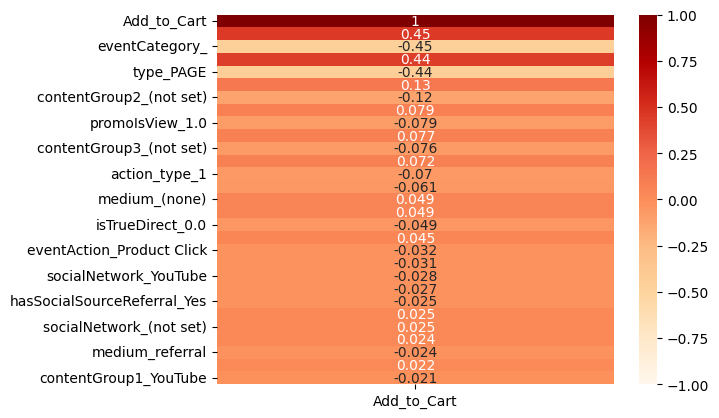

In [66]:
# Find the linear correlation of features with target
import seaborn as sns

correlated_X_y_train = pd.concat([OH_X_train, y_train], axis=1)

correlation_matrix = correlated_X_y_train.corr()

# Sort correlation by absolute correlation with target
sorted_correlation_matrix = correlation_matrix.abs().sort_values(by=y_train.name, ascending=False)

# Specify correlation threshold
threshold = 0.02

# Extract correlated features above the threshold
top_correlation_features = sorted_correlation_matrix[sorted_correlation_matrix[y_train.name] > threshold].index

print("Linear correlation with 'Add to Cart' (minimum correlation threshold 0.02)")
# Create the heatmap including the target variable
heatmap = sns.heatmap(correlation_matrix.loc[top_correlation_features, top_correlation_features[:1:]], vmin=-1, vmax=1, annot=True, cmap='OrRd')

In [68]:
print("Features correlated above 0.02 with Add to Cart:")
print(top_correlation_features)

Features correlated above 0.02 with Add to Cart:
Index(['Add_to_Cart', 'eventCategory_Enhanced Ecommerce', 'eventCategory_',
       'type_EVENT', 'type_PAGE', 'contentGroup2_Apparel',
       'contentGroup2_(not set)', 'promoIsView_0.0', 'promoIsView_1.0',
       'contentGroup3_Womens', 'contentGroup3_(not set)', 'eventAction_',
       'action_type_1', 'eventAction_Quickview Click', 'medium_(none)',
       'isTrueDirect_1.0', 'isTrueDirect_0.0', 'contentGroup2_Office',
       'eventAction_Product Click', 'medium_organic', 'socialNetwork_YouTube',
       'contentGroup2_Brands', 'hasSocialSourceReferral_Yes',
       'hasSocialSourceReferral_No', 'socialNetwork_(not set)',
       'contentGroup2_Drinkware', 'medium_referral', 'contentGroup1_(not set)',
       'contentGroup1_YouTube'],
      dtype='object')


In [70]:
# Find the Mutual Information scores of features 
from sklearn.feature_selection import mutual_info_regression

# Remove target from X, place in y 
X = OH_X_train
y = y_train

# Function to calculate Mutual Information scores using mutual_info_regression
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y) # Calculate MI scores 
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns) # Create pandas series with MI scores 
    mi_scores = mi_scores.sort_values(ascending=False) # Sort 
    return mi_scores

# Create the MI scores
mi_scores = make_mi_scores(X, y)

#Filter out MI Scores greater than 0
mi_scores_above_zero = mi_scores[mi_scores > 0.0]

#Print MI scores
print('Mutual Information Scores Above Zero')
print(mi_scores_above_zero)

Mutual Information Scores Above Zero
eventCategory_                                  0.070816
type_PAGE                                       0.070520
eventCategory_Enhanced Ecommerce                0.070171
type_EVENT                                      0.065945
contentGroup2_Apparel                           0.010228
promoIsView_0.0                                 0.008277
contentGroup2_(not set)                         0.006921
promoIsView_1.0                                 0.006644
action_type_1                                   0.006507
adContent_{KeyWord:Google Men's T-Shirts}       0.006342
socialNetwork_Pinterest                         0.004409
contentGroup3_Womens                            0.004404
eventAction_Quickview Click                     0.003809
eventAction_                                    0.003273
eventAction_Product Click                       0.003185
eventAction_Promotion Click                     0.003079
medium_organic                                  0.0

#### Features Selected from Top 10 Mutual Information (MI) Scores:
'eventCategory_Enhanced Ecommerce', 'type_PAGE' 'eventCategory_', 'type_EVENT', 'contentGroup2_(not set)', 'promoIsView_0.0', 'promoIsView_1.0', 'medium_(none)', 'action_type_1', 'eventAction_'

In [71]:
%%bigquery --project $PROJECT_ID

# Add selected featues to new table as one hot encoded variables 

CREATE OR REPLACE VIEW matt_aml_cap_dataset.ml_features_a1 AS (
    SELECT
        DISTINCT(CONCAT(fullVisitorId, visitId, h.hitNumber)) AS unique_id,
        IF(h.eventInfo.eventCategory = "Enhanced Ecommerce", 1, 0) AS h_ec_enhanced_ecommerce,
        IF(h.type = "PAGE", 1, 0) AS h_type_page,
        IF(h.type = "EVENT", 1, 0) AS h_type_event,
        IF(h.contentGroup.contentGroup2 = "(not set)", 1, 0) AS h_cg_content_group2_not_set,
        IF(h.promotionActionInfo.promoIsView = TRUE, 1, 0) AS h_pai_promoIsView_1,
        IF(h.contentGroup.contentGroup2 = "Apparel", 1, 0) AS h_cg_content_group2_apparel,
        IF(h.eCommerceAction.action_type = "1", 1, 0) AS h_ec_action_type_1,
        IF(h.eventInfo.eventAction = "Add to Cart", 1, 0) AS target
    FROM
        matt_aml_cap_dataset.ga_sessions,
    UNNEST
        (hits) AS h    
)

Query is running:   0%|          |

""


In [72]:
MODEL_NAME="add_to_cart_xgb_a1"

In [73]:
%%bigquery --project $PROJECT_ID

# Train model with selected features 

CREATE OR REPLACE MODEL matt_aml_cap_dataset.add_to_cart_xgb_a1

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["target"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="AUTO_SPLIT",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT 
    * EXCEPT(unique_id)
FROM 
    matt_aml_cap_dataset.ml_features_a1

Query is running:   0%|          |

""


In [74]:
%%bigquery --project $PROJECT_ID

# Get information on model trial show as dataframe 
SELECT 
    *
FROM
    ML.TRIAL_INFO(MODEL `matt_aml_cap_dataset.add_to_cart_xgb_a1`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 1.0},0.076775,0.076711,SUCCEEDED,None,True
1,2,"{'learn_rate': 0.0803249689834574, 'max_tree_d...",{'roc_auc': 1.0},0.111157,0.111113,SUCCEEDED,None,True
2,3,"{'learn_rate': 0.05872861451627739, 'max_tree_...",{'roc_auc': 1.0},0.171813,0.171819,SUCCEEDED,None,True
3,4,"{'learn_rate': 0.03533857523789608, 'max_tree_...",{'roc_auc': 1.0},0.285856,0.285859,SUCCEEDED,None,True
4,5,"{'learn_rate': 0.03355250620324208, 'max_tree_...",{'roc_auc': 1.0},0.297697,0.297749,SUCCEEDED,None,True
5,6,"{'learn_rate': 0.014705681049422376, 'max_tree...",{'roc_auc': 1.0},0.467865,0.467873,SUCCEEDED,None,True
6,7,"{'learn_rate': 0.01, 'max_tree_depth': 6}",{'roc_auc': 1.0},0.527913,0.527954,SUCCEEDED,None,True
7,8,"{'learn_rate': 0.0335442896896644, 'max_tree_d...",{'roc_auc': 1.0},0.297779,0.297803,SUCCEEDED,None,True


In [75]:
%%bigquery --project $PROJECT_ID

# Evaluate BigQuery model performance
SELECT
    *
FROM
    ML.EVALUATE(MODEL matt_aml_cap_dataset.add_to_cart_xgb_a1)
WHERE trial_id=8;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,8,0.861173,1.0,0.994219,0.925409,0.298622,1.0


In [76]:
%%bigquery --project $PROJECT_ID

# Look at Confusion Matrix
SELECT
    expected_label,
    _0 AS predicted_0,
    _1 AS predicted_1
FROM
    ML.CONFUSION_MATRIX(MODEL matt_aml_cap_dataset.add_to_cart_xgb_a1)
WHERE trial_id=8; 

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,31000,187
1,1,0,1160


In [77]:
%%bigquery df_ROC_AUC --project $PROJECT_ID

# Receiver Operating Characteristic - Area Under the Curve (AUC-ROC).
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `matt_aml_cap_dataset.add_to_cart_xgb_a1`,
    TABLE `matt_aml_cap_dataset.ml_features_a1`)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

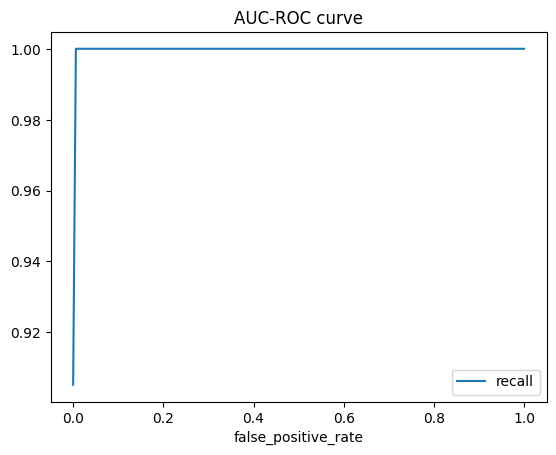

In [78]:
df_ROC_AUC.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [79]:
%%bigquery --project $PROJECT_ID

# Explain how each feature contributed to model's performance 
SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL matt_aml_cap_dataset.add_to_cart_xgb_a1)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,1,h_ec_enhanced_ecommerce,1.264831
1,1,h_ec_action_type_1,0.283578
2,1,h_cg_content_group2_not_set,0.037461
3,1,h_type_page,0.000000
4,1,h_type_event,0.000000
5,1,h_pai_promoIsView_1,0.000000
6,1,h_cg_content_group2_apparel,0.000000


#### Decision made to scrap current approach due to poor model results.

#### New Approach: Select small set of features based on documentation. Work with features only in BigQuery to get model running to acceptable level. Adjust features and tune model as neccessary if time allows. 

In [84]:
%%bigquery --project $PROJECT_ID

# Hasty-pick new features from documentation, split data, place in new table 

CREATE OR REPLACE VIEW matt_capstone_dataset.ml_features_b1 AS (
    SELECT
        *, 
        CASE
            WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) <= 7
                THEN 'TRAIN'
            WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 8
                THEN 'EVAL'
            WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 9
                THEN 'TEST'    
            ELSE '' 
        END AS data_split
    FROM(
        SELECT
            DISTINCT(CONCAT(fullVisitorId, visitId, h.hitNumber)) AS unique_id,
            ifnull(visitNumber,0) as visitNumber,
            ifnull(totals.visits,0) as totalsVisits,
            ifnull(totals.pageviews, 0) as totalsPageviews,
            ifnull(totals.timeOnSite,0) as totalsTimeOnSite,
            ifnull(h.type, 'Unknown') as hitsType,
            ifnull(h.hitNumber,0) as hitsHitNumber,
            ifnull(h.isInteraction,False) as hitIsInteraction,
            IF(h.eventInfo.eventAction = "Add to Cart", 1, 0) AS target,
        FROM
            matt_aml_cap_dataset.ga_sessions,
        UNNEST
            (hits) AS h
    )
);

Query is running:   0%|          |

""


In [85]:
%%bigquery --project $PROJECT_ID

# Check custom split
SELECT
  data_split,
  COUNT(*) AS n_examples
FROM matt_capstone_dataset.ml_features_b1
GROUP BY data_split

Query is running:   0%|          |

Downloading:   0%|          |

,data_split,n_examples
0,TRAIN,259275
1,TEST,32467
2,EVAL,32354


In [86]:
%%bigquery ml_features_b1 --project $PROJECT_ID

# Place features into DataFrame 

SELECT 
    * 
FROM 
    matt_capstone_dataset.ml_features_b1

Query is running:   0%|          |

Downloading:   0%|          |

In [87]:
ml_features_b1.shape

(324096, 10)

In [88]:
ml_features_b1.head()

,unique_id,visitNumber,totalsVisits,totalsPageviews,totalsTimeOnSite,hitsType,hitsHitNumber,hitIsInteraction,target,data_split
0,956439242905803801814990625752,1,1,2,187,PAGE,2,True,0,EVAL
1,617426845352963943114990303171,1,1,2,22,PAGE,1,True,0,TRAIN
2,223531469017642100114990641752,1,1,2,17,PAGE,2,True,0,TRAIN
3,072677777706884336314990628021,1,1,2,13,PAGE,1,True,0,TEST
4,072677777706884336314990628022,1,1,2,13,PAGE,2,True,0,TRAIN


In [89]:
ml_features_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324096 entries, 0 to 324095
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   unique_id         324096 non-null  object 
 1   visitNumber       324096 non-null  Int64  
 2   totalsVisits      324096 non-null  Int64  
 3   totalsPageviews   324096 non-null  Int64  
 4   totalsTimeOnSite  324096 non-null  Int64  
 5   hitsType          324096 non-null  object 
 6   hitsHitNumber     324096 non-null  Int64  
 7   hitIsInteraction  324096 non-null  boolean
 8   target            324096 non-null  Int64  
 9   data_split        324096 non-null  object 
dtypes: Int64(6), boolean(1), object(3)
memory usage: 24.7+ MB


In [90]:
MODEL_NAME="add_to_cart_xgb_b1"

In [91]:
%%bigquery --project $PROJECT_ID

# Train NEW model with NEW selected features 

CREATE OR REPLACE MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["target"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT 
    * EXCEPT(unique_id)
FROM 
    matt_capstone_dataset.ml_features_b1

Query is running:   0%|          |

""


In [92]:
%%bigquery --project $PROJECT_ID

# Get information on NEW model trial show as dataframe 
SELECT 
    *
FROM
    ML.TRIAL_INFO(MODEL `matt_aml_cap_dataset.add_to_cart_xgb_b1`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.9535124875124875},0.228025,0.228448,SUCCEEDED,None,True
1,2,"{'learn_rate': 0.08025234361346119, 'max_tree_...",{'roc_auc': 0.9503636363636364},0.252698,0.251882,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.0586552746062798, 'max_tree_d...",{'roc_auc': 0.9517302697302698},0.293167,0.292987,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.056854181083254685, 'max_tree...",{'roc_auc': 0.9495094905094905},0.299602,0.298634,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.0999999999999857, 'max_tree_d...",{'roc_auc': 0.9508691308691308},0.230155,0.229334,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.08489241093758355, 'max_tree_...",{'roc_auc': 0.951073926073926},0.246350,0.245478,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.08270480160761906, 'max_tree_...",{'roc_auc': 0.9508691308691308},0.247385,0.247264,SUCCEEDED,None,False
7,8,"{'learn_rate': 0.1, 'max_tree_depth': 5}",{'roc_auc': 0.9508691308691308},0.230155,0.229334,SUCCEEDED,None,False


In [93]:
%%bigquery --project $PROJECT_ID

# Evaluate BigQuery NEW model performance

SELECT
    *
FROM
    ML.EVALUATE(MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1)
WHERE trial_id=8;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,8,0.221602,0.999132,0.875443,0.362748,0.277895,0.948758


In [94]:
%%bigquery --project $PROJECT_ID

# Look at NEW Confusion Matrix

SELECT
    expected_label,
    _0 AS predicted_0,
    _1 AS predicted_1
FROM
    ML.CONFUSION_MATRIX(MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1)
WHERE trial_id=8; 

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,27272,4043
1,1,1,1151


In [95]:
%%bigquery df_ROC_AUC --project $PROJECT_ID

# Show NEW Receiver Operating Characteristic - Area Under the Curve (AUC-ROC)

SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `matt_aml_cap_dataset.add_to_cart_xgb_b1`,
    TABLE `matt_capstone_dataset.ml_features_b1`)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

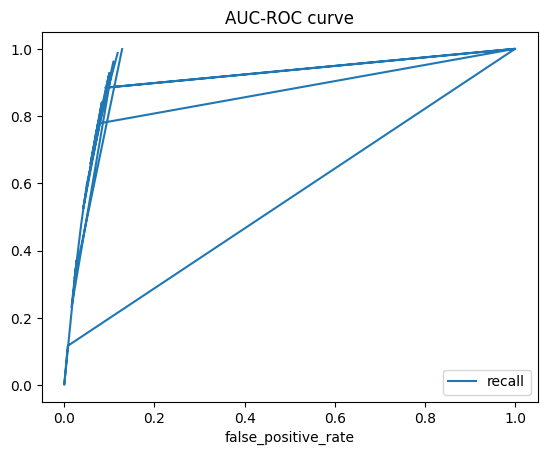

In [96]:
df_ROC_AUC.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [97]:
%%bigquery --project $PROJECT_ID

# Explain how each NEW feature contributed to NEW model's performance
SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,1,hitsType,1.160537
1,1,totalsTimeOnSite,0.092030
2,1,totalsPageviews,0.036497
3,1,hitsHitNumber,0.030797
4,1,visitNumber,0.024440
5,1,totalsVisits,0.000000
6,1,hitIsInteraction,0.000000


In [98]:
%%bigquery --project $PROJECT_ID

# Batch predict on Test data set
SELECT
  *
FROM
  ML.PREDICT(MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1,
  (SELECT * FROM matt_capstone_dataset.ml_features_b1 WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_target,predicted_target_probs,unique_id,visitNumber,totalsVisits,totalsPageviews,totalsTimeOnSite,hitsType,hitsHitNumber,hitIsInteraction,target,data_split
0,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",777893023615414946515013827571,1,1,8,281,PAGE,1,True,0,TEST
1,1,1,"[{'label': 1, 'prob': 0.785853385925293}, {'la...",721125708525972637915013965614,1,1,12,1376,EVENT,4,True,0,TEST
2,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",0167247604162700002150139520112,1,1,11,438,PAGE,12,True,0,TEST
3,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",52742678337572032515013646842,1,1,11,243,PAGE,2,True,0,TEST
4,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",5081559019693609920150138125415,9,1,10,86,PAGE,15,True,0,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32462,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",780211028496413797415002990132,1,1,3,74,PAGE,2,True,0,TEST
32463,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",87149550832349909615003407423,1,1,4,45,PAGE,3,True,0,TEST
32464,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",018282230380036985915002909813,1,1,4,83,PAGE,3,True,0,TEST
32465,1,0,"[{'label': 1, 'prob': 0.06551807373762131}, {'...",799661712715306943215002864591,2,1,4,80,PAGE,1,True,0,TEST


In [99]:
%%bigquery --project $PROJECT_ID

# Predict probability user will Add to Cart 
CREATE OR REPLACE TABLE matt_capstone_dataset.add_to_cart_predictions AS (
SELECT
  unique_id,
  target,
  predicted_target,
  predicted_target_probs[OFFSET(0)].prob as probability_add_to_cart
FROM
  ML.PREDICT(MODEL matt_aml_cap_dataset.add_to_cart_xgb_b1,
  (SELECT * FROM matt_capstone_dataset.ml_features_b1))
);

Query is running:   0%|          |

""


In [100]:
# Declare and define a BQ model and export directory 
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [101]:
# Export NEW model to GC Storage
!bq --location=$BQ_LOCATION extract --destination_format ML_XGBOOST_BOOSTER --model $BQ_MODEL $BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r6ecf779a53226389_0000018dc2f06f4b_1 ... (1s) Current status: DONE   


In [106]:
# Import the Vertex AI module
from google.cloud import aiplatform

# Create a reference to the endpoint using its resource name
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-central1/endpoints/399511947998920704')

# Undeploy the endpoint
endpoint.undeploy_all()

# Optionally, you can delete the endpoint
endpoint.delete()

Undeploying Endpoint model: projects/319407066227/locations/us-central1/endpoints/399511947998920704
Undeploy Endpoint model backing LRO: projects/319407066227/locations/us-central1/endpoints/399511947998920704/operations/6785235719867596800
Endpoint model undeployed. Resource name: projects/319407066227/locations/us-central1/endpoints/399511947998920704
Deleting Endpoint : projects/319407066227/locations/us-central1/endpoints/399511947998920704
Delete Endpoint  backing LRO: projects/319407066227/locations/us-central1/operations/6202019568123117568
Endpoint deleted. . Resource name: projects/319407066227/locations/us-central1/endpoints/399511947998920704


In [107]:
# Deploy model to endpoint
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-central1/endpoints/7619908050580668416/operations/3320841706512842752
Endpoint created. Resource name: projects/319407066227/locations/us-central1/endpoints/7619908050580668416
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-central1/endpoints/7619908050580668416')
Deploying model to Endpoint : projects/319407066227/locations/us-central1/endpoints/7619908050580668416
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-central1/endpoints/7619908050580668416/operations/3388395700923400192
Endpoint model deployed. Resource name: projects/319407066227/locations/us-central1/endpoints/7619908050580668416


In [109]:
# Set docker image
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [110]:
#Upload BQ ML model to Vertex AI from GC Storage
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-central1/models/6045728457000747008/operations/8882787246315405312
Model created. Resource name: projects/319407066227/locations/us-central1/models/6045728457000747008@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-central1/models/6045728457000747008@1')


In [111]:
# Specify categorical features for encoding 
CATEGORICAL_FEATURES = ['hitsType', 'hitIsInteraction']

In [112]:
# Bring in ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

In [113]:
# Make encoder for handling categorical features
def _build_cat_feature_encoders(categorical_feature_list, gcs_bucket, model_name, na_value='Unknown'):
    feature_encoders = {}
    
    for idx, feature in enumerate(categorical_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{GCS_BUCKET}/{MODEL_NAME}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
        
    return feature_encoders

In [114]:
# Transform instances to numerical values for inference
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)
    return transformed_instances

In [ ]:
# Rename txt files in assests folder by reindexing the prefix number corresponding to CATEGORICAL_FEATURES
# Googel Cloud User Menu > Cloud Storage > Buckets > york-bb-cohort-matt-aml-cap-bucket > add_to_cart_xgb_b1/ > assets / 
# Download 4_categorical_label.txt > rename > 0_categorical_label.txt
# Download 4_categorical_label.txt > rename > 1_categorical_label.txt
# Upload renamed files 
# Select new text file 0_categorical_label.txt > Edit metadata > Content-Type change to "application/octet-stream" > Save
# Select new text file 1_categorical_label.txt > Edit metadata > Content-Type change to "application/octet-stream" > Save

In [116]:
# Build a dictionary of ordinal categorical feature encoders
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [117]:
%%bigquery test_df --project $PROJECT_ID

# Create dataframe of Test data  
SELECT * EXCEPT(unique_id, target, data_split)
FROM matt_capstone_dataset.ml_features_4
WHERE data_split="TEST"
LIMIT 2;

Query is running:   0%|          |

Downloading:   0%|          |

In [118]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name
test_instances = test_df.astype(str).to_dict(orient='records')

In [119]:
# Preprocess to transform categorical features and return numberical instances for prediction
transformed_test_instances = preprocess_xgboost(test_instances, CATEGORICAL_FEATURES, feature_encoders)

In [120]:
# Generate predictions from model deployed to VertexAI endpoint
predictions = endpoint.predict(instances=transformed_test_instances)

In [121]:
for idx, prediction in enumerate(predictions.predictions):
    # class lables taken from model_metadata.json in gcs model directory
    # BQ ML bin classification with 0.5 and above being a prediction of add to cart
    add_to_cart = "Will Add to Cart" if prediction[0] >= 0.5 else "Will Not Add to Cart"
    print(f"Prediction: Customer {idx} - {add_to_cart} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Will Add to Cart [0.7385233044624329, 0.2614766657352448]
{"visitNumber":"1","totalsVisits":"1","totalsPageviews":"2","totalsTimeOnSite":"19","hitsType":"PAGE","hitsHitNumber":"3","hitIsInteraction":"True"}

Prediction: Customer 1 - Will Add to Cart [0.7311757206916809, 0.2688242793083191]
{"visitNumber":"1","totalsVisits":"1","totalsPageviews":"3","totalsTimeOnSite":"62","hitsType":"PAGE","hitsHitNumber":"4","hitIsInteraction":"True"}

